# Generate Order History by Customer and Aisle for PCA and Customer Segmentation Analysis
This notebook
- imports all Instacart data from PostgreSQL (User needs to store login and password in `config.py` in the same folder where this notebook is running)
- uses `merge` and `crosstab` function to generate order history data for analysis
- adds new organic category to `aisle2`
- selects approximately 20,000 customer data as training set for PCA and unsupervised training
- uses RobustScaler to transform/scale the training set data

### Import dependecies and PostgreSQL info

In [1]:
%matplotlib inline
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot as plt

# postgres login credentials and DB location
from config import pg_user, pg_pw
db_loc = 'localhost:5432'
db_name = 'p3_instacart'
engine = create_engine(f"postgresql+psycopg2://{pg_user}:{pg_pw}@{db_loc}/{db_name}")
connection = engine.connect()

### Import data to dataframes using Pandas

In [2]:
aisles = pd.read_sql("SELECT * FROM aisles", connection)
departments = pd.read_sql("SELECT * FROM departments", connection)
products = pd.read_sql("SELECT * FROM products", connection)
orders = pd.read_sql("SELECT * FROM orders", connection)
order_products = pd.read_sql("SELECT * FROM order_products", connection)

### Merge products with aisle and department data frames

In [3]:
# Joining products with aisle and department df
products_merge = products.merge(aisles, how='left', on='aisle_id').merge(departments, how='left', on='department_id')
products_merge.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


#### Edit `Aisle` data
- Because there are over 49,500 `products` in the database, `aisle` was used instead for PCA and clustering in later analysis. `Aisle` represents product categories and there are currently 134 unique aisles in the dataset. For example, the first two `aisles` in the `aisles` dataset are prepared soup salads and specialty cheeses.
- A closer examination of the categories show that these categories do not differentiate between organic and non-organic food. New `organic` categories are added to any product with organic in `product_name`

In [4]:
products_merge['aisle2'] = products_merge['product_name'].apply(lambda x: 'Organic ' if 'Organic' in x else '')
products_merge['aisle2'] = products_merge['aisle2'] + products_merge['aisle']
products_merge.drop(columns=['aisle_id', 'department_id'], inplace=True)

# print organic products
products_merge.loc[products_merge['product_name'].str.contains('Organic', case=False)]

,product_id,product_name,aisle,department,aisle2
22,23,Organic Turkey Burgers,packaged poultry,meat seafood,Organic packaged poultry
32,33,Organic Spaghetti Style Pasta,dry pasta,dry goods pasta,Organic dry pasta
40,41,Organic Sourdough Einkorn Crackers Rosemary,crackers,snacks,Organic crackers
42,43,Organic Clementines,packaged vegetables fruits,produce,Organic packaged vegetables fruits
46,47,Onion Flavor Organic Roasted Seaweed Snack,asian foods,international,Organic asian foods
...,...,...,...,...,...
49605,49606,Organic Natural Red,red wines,alcohol,Organic red wines
49607,49608,Certified Organic Spanish Style Rice With Quin...,instant foods,dry goods pasta,Organic instant foods
49637,49638,Organic Superfirm Vacuum Packed Tofu,tofu meat alternatives,deli,Organic tofu meat alternatives
49652,49653,Organic Aromatherapeutic Moroccan Argan Oil Set,soap,personal care,Organic soap


In [5]:
print(f'There are orginally {len(products_merge["aisle"].unique())} unique product categories, and {len(products_merge["aisle2"].unique())} after adding the organic tag')

There are orginally 134 unique product categories, and 258 after adding the organic tag


### Merge data frames to form order history

In [6]:
# Joining orders with order_products and products_merge
orders_history = orders.merge(order_products, on='order_id').merge(products_merge, on='product_id').sort_values(by='order_id')

# Example for `Order_id` = 1
orders_history[orders_history['order_id']==1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle,department,aisle2
23218323,1,112108,train,4,4,10,9.0,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,other creams cheeses,dairy eggs,Organic other creams cheeses
13576120,1,112108,train,4,4,10,9.0,10246,3,0,Organic Celery Hearts,fresh vegetables,produce,Organic fresh vegetables
32575950,1,112108,train,4,4,10,9.0,43633,5,1,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,canned meat seafood
4129259,1,112108,train,4,4,10,9.0,49683,4,0,Cucumber Kirby,fresh vegetables,produce,fresh vegetables
2346045,1,112108,train,4,4,10,9.0,47209,7,0,Organic Hass Avocado,fresh fruits,produce,Organic fresh fruits
281612,1,112108,train,4,4,10,9.0,13176,6,0,Bag of Organic Bananas,fresh fruits,produce,Organic fresh fruits
32723104,1,112108,train,4,4,10,9.0,49302,1,1,Bulgarian Yogurt,yogurt,dairy eggs,yogurt
4262054,1,112108,train,4,4,10,9.0,22035,8,1,Organic Whole String Cheese,packaged cheese,dairy eggs,Organic packaged cheese


`Order_ID` 1
- Bought by `user_id` 112108
- Has 8 items, half of them were first-time order
- Items include organic vegetables and cheese

### Sum Orders by User ID and Aisle/Aisle2
- Below generates a pivot table summing the each customer's purchases by `aisle` and `aisle2`, respectively
- a `Total` column added to sum total number of purchases by customer

In [7]:
orders_user_aisle = pd.crosstab(index=orders_history['user_id'], columns=orders_history['aisle'])
orders_user_aisle['Total'] = orders_user_aisle.sum(axis=1)
# show User ID 1 to 5
orders_user_aisle.head(5)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Total
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,70
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,226
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,88
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,18
5,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,46


In [8]:
#orders_user_aisle.to_csv('../Outputs/cust_order_by_aisle.csv')

In [9]:
orders_user_aisle2 = pd.crosstab(index=orders_history['user_id'], columns=orders_history['aisle2'])
orders_user_aisle2['Total'] = orders_user_aisle2.sum(axis=1)
# show User ID 1 to 5
orders_user_aisle2.head(5)

aisle2,Organic air fresheners candles,Organic asian foods,Organic baby bath body care,Organic baby food formula,Organic bakery desserts,Organic baking ingredients,Organic baking supplies decor,Organic beauty,Organic beers coolers,Organic body lotions soap,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Total
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,70
2,0,1,0,0,0,1,0,0,0,0,...,1,1,0,0,0,0,2,0,42,226
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,88
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,18
5,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,46


In [10]:
#orders_user_aisle2.to_csv('../Outputs/cust_order_by_aisle2.csv')

### Explore Customer Order Data

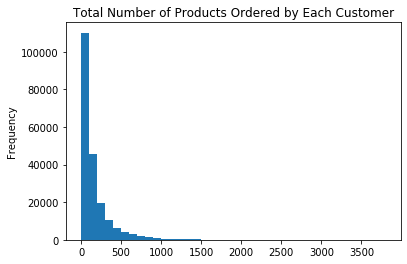

In [11]:
# Plot histogram for total # of products by customer
plt.figure()
plt.rcParams["figure.figsize"] = (12,6)
orders_user_aisle['Total'].plot(kind='hist', bins=range(0,max(orders_user_aisle['Total'])+100, 100))
plt.title('Total Number of Products Ordered by Each Customer')
plt.show()

In [12]:
orders_user_aisle['Total'].describe()

count    206209.000000
mean        164.004025
std         206.014923
min           3.000000
25%          44.000000
50%          90.000000
75%         196.000000
max        3725.000000
Name: Total, dtype: float64

In [13]:
print(f'There are {len(orders["user_id"].unique()):,} users in orders table. {len(orders_user_aisle[orders_user_aisle["Total"] >= 100]):,} of them ordered more than 100 items')

There are 206,209 users in orders table. 96,040 of them ordered more than 100 items


## Create Training Set
- There are 206,209 unique customers in the dataset, majority of them bought less than 100 items
- Randomly select approximately 20,000 customers with over 100 ordered items as training set

In [14]:
# use sklearn train_test_split module to select 
from sklearn.model_selection import train_test_split

# Original Aisle Set
cust_train, Cust_test = train_test_split(orders_user_aisle[orders_user_aisle['Total'] >= 100], train_size=0.21, random_state=42)
cust_train

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Total
user_id,,,,,,,,,,,,,,,,,,,,,
19510,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,2,4,0,9,227
147319,0,1,0,0,0,1,1,2,0,0,...,0,1,2,0,0,0,0,0,1,103
85028,0,8,0,3,126,0,1,0,0,0,...,0,0,1,0,0,0,0,0,33,731
72168,0,0,0,0,0,0,4,0,0,0,...,7,0,1,0,0,0,6,0,3,185
142535,0,1,0,0,0,0,1,0,0,0,...,1,0,2,0,1,0,9,0,0,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13607,0,0,0,0,19,0,1,0,0,0,...,0,0,11,0,0,0,0,0,43,986
117498,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,110
164881,0,1,0,0,0,0,6,0,0,0,...,0,0,0,1,0,0,1,0,10,118


In [15]:
cust_train.to_csv('../Outputs/cust_train_aisle.csv')

In [16]:
# Aisle2 Set
cust_train2, Cust_test2 = train_test_split(orders_user_aisle2[orders_user_aisle2['Total'] >= 100], train_size=0.21, random_state=42)
cust_train2

aisle2,Organic air fresheners candles,Organic asian foods,Organic baby bath body care,Organic baby food formula,Organic bakery desserts,Organic baking ingredients,Organic baking supplies decor,Organic beauty,Organic beers coolers,Organic body lotions soap,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Total
user_id,,,,,,,,,,,,,,,,,,,,,
19510,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,2,4,0,8,227
147319,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,103
85028,0,0,0,44,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,33,731
72168,0,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,6,0,2,185
142535,0,0,0,0,0,0,0,0,0,0,...,1,0,2,0,1,0,9,0,0,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13607,0,0,0,13,0,1,0,0,0,0,...,0,0,6,0,0,0,0,0,17,986
117498,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,110
164881,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,10,118


In [17]:
cust_train2.to_csv('../Outputs/cust_train_aisle2.csv')

### Transform/Scale Data using RobustScaler

In [18]:
from sklearn.preprocessing import RobustScaler

In [19]:
scaler = RobustScaler()

##### `aisle` set

In [20]:
cust_train_rescaled = scaler.fit_transform(cust_train)
df_cust_train_rs = pd.DataFrame(cust_train_rescaled, columns=orders_user_aisle.columns)
df_cust_train_rs.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Total
0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.250,0.0,0.200000,0.073394
1,0.0,0.5,0.0,0.0,0.0,1.0,0.00,2.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,-0.250,0.0,-0.333333,-0.495413
2,0.0,4.0,0.0,3.0,126.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,-0.250,0.0,1.800000,2.385321
3,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,...,3.5,0.0,0.5,0.0,0.0,0.0,0.500,0.0,-0.200000,-0.119266
4,0.0,0.5,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.5,0.0,1.0,0.0,1.0,0.0,0.875,0.0,-0.400000,-0.481651


In [21]:
df_cust_train_rs.to_csv('../Outputs/cust_train_aisle_rescale.csv')

##### `aisle2` set

In [22]:
cust_train_rescaled2 = scaler.fit_transform(cust_train2)
df_cust_train_rs2 = pd.DataFrame(cust_train_rescaled2, columns=orders_user_aisle2.columns)
df_cust_train_rs2.head()

aisle2,Organic air fresheners candles,Organic asian foods,Organic baby bath body care,Organic baby food formula,Organic bakery desserts,Organic baking ingredients,Organic baking supplies decor,Organic beauty,Organic beers coolers,Organic body lotions soap,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Total
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,2.0,0.250,0.0,0.363636,0.073394
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,-0.250,0.0,-0.272727,-0.495413
2,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.250,0.0,2.636364,2.385321
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,-0.181818,-0.119266
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,1.0,0.0,0.875,0.0,-0.363636,-0.481651


In [23]:
df_cust_train_rs2.to_csv('../Outputs/cust_train_aisle_rescale2.csv')